# This code demonstrates value of hyperparameter tuning (Example Gym: Anytrading Gym Environment)

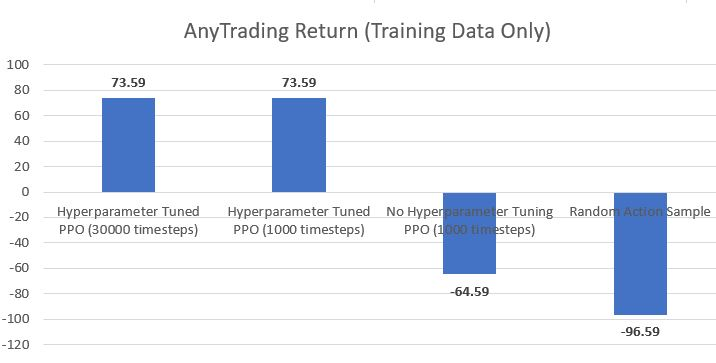
### Code written by Chirag Mirani, March 7, 2022. 

In [63]:

# importing library
import numpy as np
from stable_baselines3.common.vec_env import SubprocVecEnv
from stable_baselines3 import PPO
import optuna
import gym
from torch import nn as nn
import joblib
import gym_anytrading
import yfinance as yf
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize
from matplotlib import pyplot as plt
import finta as TA #technical indicators library imported..
from gym_anytrading.envs import StocksEnv
from gym import Env
from gym.spaces import Discrete, Box
from gym import spaces
from gym.utils import seeding
import pandas as pd

In [64]:

# define optimization agent for Optuna
#Runs per trial model to make sure that runs are generally positive
nOptimzeRuns = 10
#training timesteps per trial
nOptimizeTrains = 10000
# number of optuna trials
nOptunaTrials = 10


In [65]:
class StockTradingEnv(Env):
    
    # constructor of our class
    def __init__(self, df, out_csv_name, window_size=1, frame_bound=(1,30), loss=-40/100):
        assert df.ndim == 2
        assert len(frame_bound) == 2

        
        self.frame_bound = (1,df.shape[0])

        
        # Actions space is defined from 1 to 20,
        #there are 10 actions for Buy, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10 (Buy 1, 2, ...10 stocks)
        #there are 10 actions for Sell,11,12,13,14,15,16,17,18,19,20 (sell -1, -2, -3 stocks)
        #self.action_space = Box(low=1, high=20, shape=(1, ), dtype=np.int16)
        #Discrete(3, start=-1)  # {-1, 0, 1}
        self.action_space = spaces.Discrete(20)
        
        ## set the seed
        self.seed()
        
        # set the data frame
        self.df = df
        #set window size
        # how long is the look back window 1
        self.window_size = window_size
        
        #set loss constraint
        self.loss = loss
        
        #extract prices and features..
        
        self.prices, self.signal_features = self._process_data()
        #print(self.prices)
        
        
        # TODO check this with spy trading shape...how long is the look back period and the number of features
        self.shape = (window_size, self.signal_features.shape[1])

        # spaces
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=self.shape, dtype=np.float32)

        # episode
        #print(len(self.prices))
        self._length = len(self.prices)
        self._start_tick = self.window_size
        self._end_tick = len(self.prices)-1
        #print("start tick: ", self._start_tick, "End tick: ", self._end_tick)
        self._done = None
        self._current_tick = None
        self._last_trade_tick = None
        self._position = 0
        self._position_history = []
        self._total_reward = None
        self._total_profit = None
        self.history = None
        
        #reporting 
        self._direction = "Neutral"
        self._contracts = 0
        self._entry = 0
        self._exit = 0
        self._UnleveredReturn = 0
        self._LeveredReturn = 0
        self._CumulativeLeveredReturn = 0

        self.out_csv_name = out_csv_name
        self.metrics = []
        self.run = 0
        self.step_index = 0

    #set a random seed
    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]
   
        
    # what happens when we step forward in time...
    def step(self, action):
        self.step_index +=1
        self._done = False
        # ** TODO: use a dictionary
        #*****************************
        #print("action: ", action[0])
        action = action + 1
        if action <=10:
            self._position = action
            self._direction = "BUY"
        
        else:
            self._position = 10-action
            self._direction = "SELL"
        #*****************************
        
        # Storing number of contracts executed
        self._contracts = np.abs(self._position)
        
        
        self._current_tick =self._current_tick+ 1
        self._last_trade_tick=self._current_tick-1
        
        
        # now calculate reward
        # get the one step ahead price.  We are using _current_tick because that has already been pushed forward
        # by one step. 
        current_price = self.prices[self._current_tick]
        # get the previous step price
        last_trade_price = self.prices[self._last_trade_tick]
        # get the return * positionsize by achieved by taking step
        price_diff = np.log(current_price/last_trade_price) * self._position
        
            #self._done=True
        # say you buy a stock: all I care about for rewards is returns not dollar amounts..maximize return
        # underconstraint total return doesn't go below my stoploss
        
        # set the price return * position size equal to the reward for taking this step..
        step_reward = price_diff
        # update cumulative reward
        self._total_reward += step_reward
        
        self._entry = last_trade_price
        self._exit = current_price
        self._UnleveredReturn = np.log(current_price/last_trade_price)*(self._position/self._contracts)
        self._LeveredReturn = price_diff
        self._CumulativeLeveredReturn = self._total_reward

        #self._last_trade_tick = self._current_tick
        #print(self._done)
          
        # if the cumulative reward is less than defined loss, set done is equal to true
        if self._total_reward < self.loss:
            self._done=True
            #step_reward = -1000
        #print()
        
        # I want to maximize cumulativeleveredreturns under the constraint that we never lose more than the stoploss
 
            #self._done=False
        
        info_save = self._compute_step_info(step_reward)
        self.metrics.append(info_save)

        if self._done or self.step_index % 1000==0:
            current_price = self.prices[self._current_tick]
            last_trade_price = self.prices[self._last_trade_tick]
            
            self.save_csv(self.out_csv_name, self.run)
            self.run += 1
            self.metrics = []
            self.step_index = 0

        #not sure what this code block is but I think it keeps track of 
        # current reward, cumulative reward and position 
        self._last_trade_tick = self._current_tick
        
        # add self position 
        #store direction of the position
        self._position_history.append(self._position)
        
        # returns the observation from last step
        observation = self._get_observation()
        
        # store current return profit (action * return)
        # store cumulative return..
        # store your current position, which is your action
        total_reward = step_reward,
        total_profit = total_reward,
        position = self._position
        self._total_profit = np.round(self._CumulativeLeveredReturn*100,3)
        
        info = dict(
            Direction = self._direction, 
            Contracts = self._contracts,
            EntryPriceUSD = np.round(self._entry,2),
            ExitPriceUSD = np.round(self._exit,2),
            UnleveredReturn = np.round(self._UnleveredReturn*100,3),
            LeveredReturn=np.round(self._LeveredReturn*100,3),
            CumulativeLeveredReturn = np.round(self._CumulativeLeveredReturn*100,3),
            Length = self._length
            
        )
        
        
        # pass your stored information to your history...
        self._update_history(info)
        #print(len(self.prices))
        if self._current_tick == self._end_tick:
            self._done = True
        
        #self._last_trade_tick = self._current_tick
        
        # return observation, step_reward, whether we are done or not, info
        return observation, step_reward, self._done, info
    
    # get observations...
    def _get_observation(self):
        return self.signal_features[(self._current_tick-self.window_size):self._current_tick]

    # update history. This function stores current reward, cumulative reward and current history
    def _update_history(self, info):
        if not self.history:
            self.history = {key: [] for key in info.keys()}

        for key, value in info.items():
            self.history[key].append(value)

        
        
    # showing charts in this function 
    def render(self):
        #Implement visualization
        pass
    
    # resetting the environment
    def reset(self):
        
        #done is used to see if we have run through all the data
        self._done = False
        
        #sets the current price to starting price
        self._current_tick = self._start_tick
        #sets the last price to the previous price
        self._last_trade_tick = self._current_tick - 1
        
        #default position is short
        self._position = 0
        
        # length of position history
        #self._position_history = (self.window_size * [None]) + [self._position]
        #sets current reward
        self._total_reward = 0.
        
        #sets total profit back to zero
        self._total_profit = 0  
        
        # set history to be blank
        self.history = {}
        
        # set reporting data back to beginning state
        self._direction = "Neutral"
        self._contracts = 0
        self._entry = 0
        self._exit = 0
        self._UnleveredReturn = 0
        self._LeveredReturn = 0
        self._CumulativeLeveredReturn = 0

        return self._get_observation()

    #processing data, simple featuer calculation. this should be extended to include your own features
    def _process_data(self):
        
        #get prices from dataframe column 'Close'
        prices = self.df.loc[:, 'Close'].to_numpy()
        
        # grab prices
        prices[self.frame_bound[0] - self.window_size]  # validate index (TODO: Improve validation)
        prices = prices[self.frame_bound[0]-self.window_size:self.frame_bound[1]]
        #print(prices.shape)
        # get price difference
        diff = np.insert(np.diff(prices), 0, 0)
        
        # features will be prices and stacked columns..
        signal_features = np.column_stack((prices, diff))

        return prices, signal_features



    # this will render buying in selling
    def render_all(self):
        # get the number of data points
        window_ticks = np.arange(len(self._position_history))
        
        # plot the prices
        plt.plot(self.prices)

        # on the prices store long or short
        # figure out prices where you are ahort
        # figure out prices where you are long
        short_ticks = []
        long_ticks = []
        
        # do this for each tick. is it long? is it short?
        #print(window_ticks)

        for i, tick in enumerate(window_ticks):
            #print(i)
            if self._position_history[i] < 0:
                short_ticks.append(tick+1)
            else:    
                long_ticks.append(tick+1)
        # make short ticks red
        #print(short_ticks)
        #print(long_ticks)
        plt.plot(short_ticks, self.prices[short_ticks], 'ro')
        
        #make long ticks red
        plt.plot(long_ticks, self.prices[long_ticks], 'go')

        #make a subtitle to be to the total cumulative gain/profit of the strategy
        plt.suptitle("Total Cumulative Return (Percent): %.3f" % self._total_profit)
    
    def _compute_step_info(self, reward):
        return {
            'Direction': self._direction,
            'Contracts': self._contracts,
            'EntryPriceUSD': np.round(self._entry,2),
            'ExitPriceUSD': np.round(self._exit,2),
            'UnleveredReturn': np.round(self._UnleveredReturn*100,3),
            'LeveredReturn': np.round(self._LeveredReturn*100,3),
            'CumulativeLeveredReturn': np.round(self._CumulativeLeveredReturn*100,3),
            'Reward': reward
        }

    def save_csv(self, out_csv_name, run):
        if out_csv_name is not None:
            df = pd.DataFrame(self.metrics)
            #df.to_csv(out_csv_name + '_run{}'.format(run) + '.csv', index=False)

In [66]:
# callback class for Optuna early stopping
# Reference: https://medium.com/analytics-vidhya/hyperparameter-tuning-using-optuna-for-finrl-8a49506d2741
class LoggingCallback:
    def __init__(self,threshold,trial_number,patience):
      '''
      threshold:int tolerance for increase in reward
      trial_number: int Prune after minimum number of trials
      patience: int patience for the threshold
      '''
      self.threshold = threshold
      self.trial_number  = trial_number
      self.patience = patience
      self.cb_list = [] #Trials list for which threshold is reached
    def __call__(self,study:optuna.study, frozen_trial:optuna.Trial):
      #Setting the best value in the current trial
      study.set_user_attr("previous_best_value", study.best_value)
      
      #Checking if the minimum number of trials have pass
      if frozen_trial.number >self.trial_number:
          previous_best_value = study.user_attrs.get("previous_best_value",None)
          #Checking if the previous and current objective values have the same sign
          if previous_best_value * study.best_value >=0:
              #Checking for the threshold condition
              if abs(previous_best_value-study.best_value) < self.threshold: 
                  self.cb_list.append(frozen_trial.number)
                  #If threshold is achieved for the patience amount of time
                  if len(self.cb_list)>self.patience:
                      print('The study stops now...')
                      print('With number',frozen_trial.number ,'and value ',frozen_trial.value)
                      print('The previous and current best values are {} and {} respectively'
                              .format(previous_best_value, study.best_value))
                      study.stop()


In [67]:
# add features..
#read spy data
df = yf.download('SPY', start='2021-11-06', end='2022-02-06', progress=False)
df.drop("Close", axis=1, inplace=True)
df.rename(columns = {'Adj Close':'Close'}, inplace = True)
df.head()
df.fillna(0,inplace=True)
df.drop(df.tail(1).index,inplace=True) # drop last n rows
df.shape

(61, 5)

In [68]:
# create environment
env = StockTradingEnv(out_csv_name='results/rewards.csv', df=df)
env_maker = lambda: env
env = DummyVecEnv([env_maker])
env = VecNormalize(env, norm_obs=True, norm_reward=True)


In [69]:
n_cpu = 8

## define PPO hyperparameters

def optimize_ppo(trial):
    """ Learning hyperparamters we want to optimise"""
    #net_arch = trial.suggest_categorical("net_arch", ["small", "medium"])
    #activation_fn = trial.suggest_categorical("activation_fn", ["tanh", "relu"])
    #net_arch = { "small": [dict(pi=[64, 64], vf=[64, 64])], "medium": [dict(pi=[256, 256], vf=[256, 256])],}[net_arch]

    #activation_fn = {"tanh": nn.Tanh, "relu": nn.ReLU, "elu": nn.ELU, "leaky_relu": nn.LeakyReLU}[activation_fn]
    ortho_init = False
    return {
         'gamma': trial.suggest_categorical("gamma", [0.9, 0.95, 0.98, 0.99, 0.995, 0.999, 0.9999]),
         'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1.),
          #'n_steps': trial.suggest_categorical("n_steps", [8, 16, 32, 64, 128, 256, 512, 1024, 2048]),
           #'n_epochs': trial.suggest_categorical("n_epochs", [1, 5, 10, 20]),
            'batch_size': trial.suggest_categorical("batch_size", [8, 16, 32, 64, 128, 256, 512]),
            #'clip_range': trial.suggest_categorical("clip_range", [0.1, 0.2, 0.3, 0.4]),
            #'vf_coef': trial.suggest_uniform("vf_coef", 0, 1),
            #'ent_coef': trial.suggest_loguniform("ent_coef", 0.00000001, 0.1),
            #'max_grad_norm': trial.suggest_categorical("max_grad_norm", [0.3, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 2, 5]),
            #'gae_lambda': trial.suggest_categorical("gae_lambda", [0.8, 0.9, 0.92, 0.95, 0.98, 0.99, 1.0]),
            #"policy_kwargs": dict(net_arch=net_arch,activation_fn=activation_fn, ortho_init=ortho_init,)
         }

def optimize_agent(trial):
    """ Train the model and optimise
        Optuna maximises the negative log likelihood, so we
        need to negate the reward here
    """
    #env_params = optimize_env(trial)
    model_params = optimize_ppo(trial)
    #env = SubprocVecEnv([lambda: gym.make('CartPole-v1') for i in range(n_cpu)])
    #env = gym.make('CartPole-v1')
    #env = gym.make('stocks-v0', df=df, frame_bound=(start_index,end_index), window_size=window_size)
    rewards = []
    n_episodes, reward_sum = 0, 0.0

    for i in range(nOptimzeRuns):
        model = PPO('MlpPolicy', env, verbose=0, **model_params)
        model.learn(nOptimizeTrains)
        model.save('PPO_{}.pth'.format(trial.number))
        obs = env.reset()
        n_episodes, reward_sum = 0, 0.0

        while n_episodes < 1:

            #action, _ = model.predict(obs, deterministic=True)
            action, _ = model.predict(obs)
           
            obs, reward, done, info = env.step(action)


            if done:
                rewards.append((info[0]["CumulativeLeveredReturn"]))
                #print(info["CumulativeLeveredReturn"])
                #print(rewards)
                n_episodes += 1
                obs = env.reset()
        
    print(rewards)    
        #rewards.append(validate(env, model)) # validate is you while loop
    return np.min(rewards) 

    #model = PPO('MlpPolicy', env, verbose=0, **model_params, seed = 42)
    #model.learn(2000)
    #model.save('PPO_{}.pth'.format(trial.number))

    
    #env.render()
    #print(rewards)
    #last_reward = rewards
    #trial.report(-1 * last_reward)
    #return last_reward


In [70]:
# set an optuna sampler, TPE is the best
sampler = optuna.samplers.TPESampler(seed=42)

# setup study environment for Optuna
study = optuna.create_study(study_name="PPO_study",direction='maximize',
                            sampler = sampler, pruner=optuna.pruners.HyperbandPruner())

# setup early callback
logging_callback = LoggingCallback(threshold=1e-5,patience=200,trial_number=30)


[I 2022-03-09 15:44:52,692] A new study created in memory with name: PPO_study


In [ ]:
# run optuna for ten trials
study.optimize(optimize_agent, n_trials=nOptunaTrials,catch=(ValueError,),callbacks=[logging_callback])


In [40]:
# record and best parameters
trial = study.best_trial
print(study.best_trial.number)
print('Reward: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))
#joblib.dump(study, "final_ddpg_study__.pkl")

96
Reward: 1.395
Best hyperparameters: {'gamma': 0.995, 'learning_rate': 0.7610261242764104, 'batch_size': 512}


In [41]:
#now use the best model and check your score
#env = gym.make('CartPole-v1')
#env = gym.make('stocks-v0', df=df, frame_bound=(start_index,end_index), window_size=window_size)

#use saved model: study.best_trial.number
print(study.best_trial.number)
tuned_model_PPO = PPO.load('PPO_{}.pth'.format(study.best_trial.number),env=env)

rewards = []
n_episodes, reward_sum = 0, 0.0

obs = env.reset()
#print(obs)
#env.render()
while n_episodes < 1:
    #env.render()
    action, _ = tuned_model_PPO.predict(obs, deterministic=True)
    obs, reward, done, info = env.step(action)
    print(info)
    #if(action)>11:
        #print(obs)
        #print("SELL")
    #reward_sum += reward
    #print(action)

    if done:
        rewards = (info[0]["CumulativeLeveredReturn"])
        print(info)
        n_episodes += 1
        obs = env.reset()


env.close()
last_reward = rewards
#trial.report(-1 * last_reward)
print(last_reward)


96
[{'Direction': 'SELL', 'Contracts': 2, 'EntryPriceUSD': 465.74, 'ExitPriceUSD': 462.0, 'UnleveredReturn': 0.808, 'LeveredReturn': 1.615, 'CumulativeLeveredReturn': 1.615, 'Length': 61}]
[{'Direction': 'SELL', 'Contracts': 2, 'EntryPriceUSD': 462.0, 'ExitPriceUSD': 462.15, 'UnleveredReturn': -0.032, 'LeveredReturn': -0.065, 'CumulativeLeveredReturn': 1.551, 'Length': 61}]
[{'Direction': 'SELL', 'Contracts': 2, 'EntryPriceUSD': 462.15, 'ExitPriceUSD': 465.63, 'UnleveredReturn': -0.752, 'LeveredReturn': -1.504, 'CumulativeLeveredReturn': 0.047, 'Length': 61}]
[{'Direction': 'SELL', 'Contracts': 2, 'EntryPriceUSD': 465.63, 'ExitPriceUSD': 465.79, 'UnleveredReturn': -0.034, 'LeveredReturn': -0.068, 'CumulativeLeveredReturn': -0.021, 'Length': 61}]
[{'Direction': 'SELL', 'Contracts': 2, 'EntryPriceUSD': 465.79, 'ExitPriceUSD': 467.64, 'UnleveredReturn': -0.395, 'LeveredReturn': -0.79, 'CumulativeLeveredReturn': -0.811, 'Length': 61}]
[{'Direction': 'SELL', 'Contracts': 2, 'EntryPriceUSD':

In [42]:
# Now train your own model without tuning
#env = gym.make('CartPole-v1')
#env = gym.make('stocks-v0', df=df, frame_bound=(start_index,end_index), window_size=window_size)

#study.best_trial.number
#tuned_model_PPO = PPO.load('PPO_{}.pth'.format(study.best_trial.number),env=env)
nontuned_model_PPO = PPO('MlpPolicy', env, verbose=0)
nontuned_model_PPO.learn(1000)
    
# {'gamma': 0.95, 'learning_rate': 0.45090492266587917, 'batch_size': 8}. Best is trial 85 with value: 41.8285.


In [44]:
# compare the scores
rewards = []
n_episodes, reward_sum = 0, 0.0

obs = env.reset()
#env.render()
while n_episodes < 1:
    
    action, _ = nontuned_model_PPO.predict(obs, deterministic=True)
    #print(action)
    obs, reward, done, info = env.step(action)
    #reward_sum += reward

    if done:
        rewards = (info[0]["CumulativeLeveredReturn"])
        n_episodes += 1
        obs = env.reset()


env.close()
last_reward = rewards
#trial.report(-1 * last_reward)
print(last_reward)

80.715


In [45]:
# check score for random sample...
rewards = []
n_episodes, reward_sum = 0, 0.0
#env = gym.make('stocks-v0', df=df, frame_bound=(start_index,end_index), window_size=window_size)

obs = env.reset()
#env.render()
while n_episodes < 1:
    #action, _ = env.action_space.sample()
    #action, _ = tuned_model_PPO.predict(env.action_space.sample())
    action = env.action_space.sample()
    #print(action)
    obs, reward, done, info = env.step([action])
    #reward_sum += reward

    if done:
        rewards = (info[0]["CumulativeLeveredReturn"])
        n_episodes += 1
        obs = env.reset()


env.close()
last_reward = rewards
#trial.report(-1 * last_reward)
print(last_reward)


-6.575


In [47]:
#Now build your own model from the parameters and run it
#env = gym.make('CartPole-v1')
#env = gym.make('stocks-v0', df=df, frame_bound=(start_index,end_index), window_size=window_size)

trial = study.best_trial
#print(trial.number)
model_params = optimize_ppo(trial)
# {'gamma': 0.95, 'learning_rate': 0.45090492266587917, 'batch_size': 8}. Best is trial 85 with value: 41.8285.
#best_trial_parameters_model = PPO('MlpPolicy', env, verbose=0, gamma=0.95, learning_rate=0.45090492266587917, batch_size=8)

best_trial_parameters_model = PPO('MlpPolicy', env, verbose=0, **model_params)
best_trial_parameters_model.learn(1000)
rewards = []
n_episodes, reward_sum = 0, 0.0

obs = env.reset()
#env.render()
while n_episodes < 1:
    #env.render()
    action, _ = best_trial_parameters_model.predict(obs, deterministic=True)
    print(action)
    obs, reward, done, info = env.step(action)
    #print(info)
    #reward_sum += reward

    if done:
        rewards = (info[0]["CumulativeLeveredReturn"])
        n_episodes += 1
        obs = env.reset()


env.close()
last_reward = rewards
#trial.report(-1 * last_reward)
print(last_reward)

[6]
[6]
[6]
[6]
[6]
[6]
[6]
[6]
[6]
[6]
[6]
[6]
[6]
[6]
[6]
[6]
[6]
[6]
[6]
[6]
[6]
[6]
[6]
[6]
[6]
[6]
[6]
[6]
[6]
[6]
[6]
[6]
[6]
[6]
[6]
[6]
[6]
[6]
[6]
[6]
[6]
[6]
[6]
[6]
[6]
[6]
[6]
[6]
[6]
[6]
-43.024


In [48]:
trial = study.best_trial
#print(trial.number)
model_params = optimize_ppo(trial)
best_trial_parameters_model = PPO('MlpPolicy', env, verbose=0, **model_params)
best_trial_parameters_model.learn(10000)
rewards = []
n_episodes, reward_sum = 0, 0.0

obs = env.reset()
#env.render()
while n_episodes < 1:
    #env.render()
    action, _ = best_trial_parameters_model.predict(obs, deterministic=True)
    #print(action)
    obs, reward, done, info = env.step(action)
    #reward_sum += reward

    if done:
        rewards = (info[0]["CumulativeLeveredReturn"])
        n_episodes += 1
        obs = env.reset()


env.close()
last_reward = rewards
#trial.report(-1 * last_reward)
print(last_reward)

46.768


In [52]:
trial = study.best_trial
#print(trial.number)
model_params = optimize_ppo(trial)
best_trial_parameters_model = PPO('MlpPolicy', env, verbose=0, **model_params)
best_trial_parameters_model.learn(20000)
rewards = []
n_episodes, reward_sum = 0, 0.0

obs = env.reset()
#env.render()
while n_episodes < 1:
    #env.render()
    action, _ = best_trial_parameters_model.predict(obs, deterministic=True)
    print(action)
    obs, reward, done, info = env.step(action)
    print(info)
    #reward_sum += reward

    if done:
        rewards = (info[0]["CumulativeLeveredReturn"])
        n_episodes += 1
        obs = env.reset()


env.close()
last_reward = rewards
#trial.report(-1 * last_reward)
print(last_reward)

[8]
[{'Direction': 'BUY', 'Contracts': 9, 'EntryPriceUSD': 465.74, 'ExitPriceUSD': 462.0, 'UnleveredReturn': -0.808, 'LeveredReturn': -7.27, 'CumulativeLeveredReturn': -7.27, 'Length': 61}]
[8]
[{'Direction': 'BUY', 'Contracts': 9, 'EntryPriceUSD': 462.0, 'ExitPriceUSD': 462.15, 'UnleveredReturn': 0.032, 'LeveredReturn': 0.291, 'CumulativeLeveredReturn': -6.979, 'Length': 61}]
[16]
[{'Direction': 'SELL', 'Contracts': 7, 'EntryPriceUSD': 462.15, 'ExitPriceUSD': 465.63, 'UnleveredReturn': -0.752, 'LeveredReturn': -5.263, 'CumulativeLeveredReturn': -12.241, 'Length': 61}]
[8]
[{'Direction': 'BUY', 'Contracts': 9, 'EntryPriceUSD': 465.63, 'ExitPriceUSD': 465.79, 'UnleveredReturn': 0.034, 'LeveredReturn': 0.308, 'CumulativeLeveredReturn': -11.933, 'Length': 61}]
[8]
[{'Direction': 'BUY', 'Contracts': 9, 'EntryPriceUSD': 465.79, 'ExitPriceUSD': 467.64, 'UnleveredReturn': 0.395, 'LeveredReturn': 3.555, 'CumulativeLeveredReturn': -8.378, 'Length': 61}]
[8]
[{'Direction': 'BUY', 'Contracts': 9,

In [ ]:
trial = study.best_trial
#print(trial.number)
model_params = optimize_ppo(trial)
best_trial_parameters_model = PPO('MlpPolicy', env, verbose=0, **model_params)
best_trial_parameters_model.learn(2000000)
rewards = []
n_episodes, reward_sum = 0, 0.0

obs = env.reset()
#env.render()
while n_episodes < 1:
    #env.render()
    action, _ = best_trial_parameters_model.predict(obs, deterministic=True)
    #print(action)
    obs, reward, done, info = env.step(action)
    #reward_sum += reward

    if done:
        rewards = (info[0]["CumulativeLeveredReturn"])
        n_episodes += 1
        obs = env.reset()


env.close()
last_reward = rewards
#trial.report(-1 * last_reward)
print(last_reward)